In [1]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O cats_and_dogs_filtered.zip

--2021-07-22 20:35:06--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 142.250.101.128, 142.250.141.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  76.5MB/s    in 0.9s    

2021-07-22 20:35:08 (76.5 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
! unzip -q cats_and_dogs_filtered.zip

replace cats_and_dogs_filtered/vectorize.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [3]:
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input
import numpy as np

In [4]:
train_dir = "cats_and_dogs_filtered/train/"
validation_dir = "cats_and_dogs_filtered/validation/"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True
    )

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Reescribir la red utilizando el método funcional y definiendo una función de ayuda.

In [5]:
## inputs = Input(shape=(224,224,3)), etc.
def create_block(n_filters, n_layers, inputs):
    '''
    Entradas:
     n_filters: numero de filtros del bloque
     n_layers: número de capas del bloque
     inputs: tensor de entrada
    Retorna:
     tensor de salida con las capas aplicadas
    '''
    # usar un bucle for para agregar n_layers capas convolucionales
    # luego, agregar la capa MaxPool2D y retornarla
    for i in range(n_layers):
      inputs = Conv2D(filters=n_filters,kernel_size=(3,3),padding="same", kernel_initializer='he_normal',\
                      activation="relu")(inputs)
    inputs=MaxPool2D(pool_size=(2,2),strides=(2,2))(inputs)
    return inputs # retornar el tensor
    

#model = Sequential()
#model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
#model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
#model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
#model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
#model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
#model.add(Flatten())
#model.add(Dense(units=4096,activation="relu"))
#model.add(Dense(units=4096,activation="relu"))
#model.add(Dense(units=2, activation="softmax"))

# reemplazar los bloques usando la función create_block
inputs = Input(shape=(224,224,3))
x = create_block(64,2,inputs)
x = create_block(128,2,x)
x = create_block(256,3,x)
x = create_block(512,3,x)
x = create_block(512,3,x)
x = Flatten()(x)
x = Dense(units=4096,activation="relu")(x)
x = Dense(units=4096,activation="relu")(x)
x = Dense(units=1, activation="sigmoid")(x)
model = Model(inputs, x)


from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import categorical_crossentropy
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [6]:
NNfrom tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_accuracy', verbose=2, save_best_only=True, 
                             save_weights_only=False, mode='auto')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')


In [8]:
hist = model.fit_generator(steps_per_epoch=100,generator=train_generator, validation_data= validation_generator, validation_steps=10,epochs=20,callbacks=[checkpoint,early])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
100/100 [==============================] - 50s 394ms/step - loss: 1.9334 - accuracy: 0.5130 - val_loss: 0.7563 - val_accuracy: 0.4550

Epoch 00001: val_accuracy improved from -inf to 0.45500, saving model to vgg16_1.h5
Epoch 2/20
100/100 [==============================] - 39s 391ms/step - loss: 0.7706 - accuracy: 0.5205 - val_loss: 0.6898 - val_accuracy: 0.5200

Epoch 00002: val_accuracy improved from 0.45500 to 0.52000, saving model to vgg16_1.h5
Epoch 3/20
100/100 [==============================] - 40s 395ms/step - loss: 0.7068 - accuracy: 0.5650 - val_loss: 0.6837 - val_accuracy: 0.5200

Epoch 00003: val_accuracy did not improve from 0.52000
Epoch 4/20
100/100 [==============================] - 38s 382ms/step - loss: 0.6952 - accuracy: 0.6045 - val_loss: 1.6746 - val_accuracy: 0.5800

Epoch 00004: val_accuracy improved from 0.52000 to 0.58000, saving model to vgg16_1.h5
Epoch 5/20
100/100 [==============================] - 39s 391ms/step - loss: 0.6932 - accuracy: 0.6325 

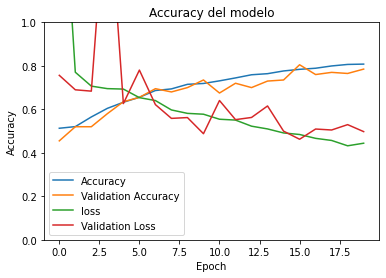

In [9]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylim((0,1))
plt.title("Accuracy del modelo")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [12]:
arena_generator = test_datagen.flow_from_directory(
        './Arena',
        target_size=(224, 224))

Found 3 images belonging to 2 classes.


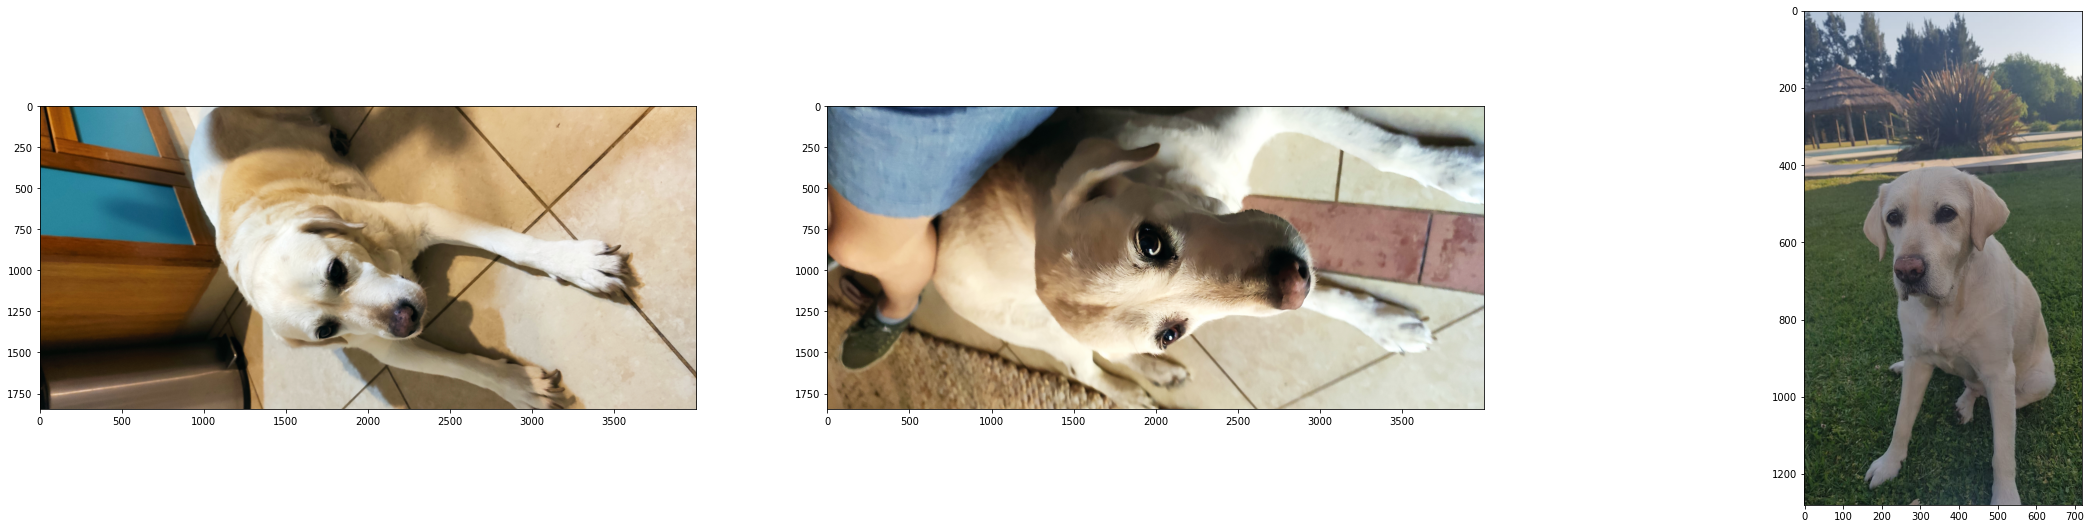

In [19]:
import matplotlib.image as mpimg
import glob
import os

files =glob.glob("./Arena/img/*.jpg")
plt.figure(figsize=(40,20))
i=1
for f in files:
  plt.subplot(2,3,i)
  image = mpimg.imread(f)
  plt.imshow(image)
  i+=1
    
plt.show()

In [15]:
import tensorflow as tf
saved_model = tf.keras.models.load_model("vgg16_1.h5", compile=False)
predictions=saved_model.predict(arena_generator)
for output in predictions:
  if output<0.5:
      print("cat")
  else:
      print('dog')

dog
dog
dog


In [20]:
popy_generator = test_datagen.flow_from_directory(
        './Popy',
        target_size=(224, 224),
        batch_size=4,
        shuffle=False)

Found 4 images belonging to 2 classes.


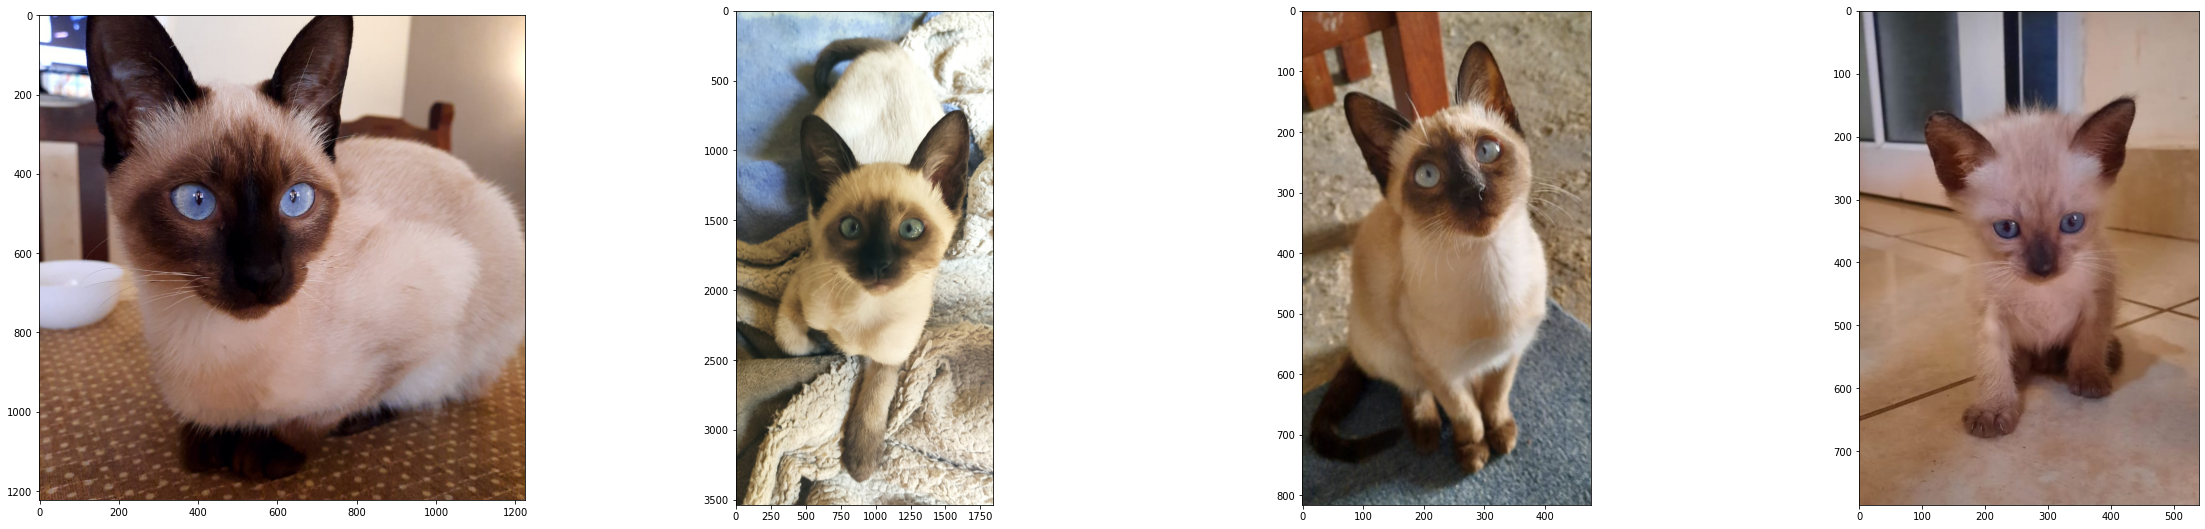

In [21]:
files =glob.glob("./Popy/img/*.jpg")
plt.figure(figsize=(40,20))
i=1
for f in files:
  plt.subplot(2,4,i)
  image = mpimg.imread(f)
  plt.imshow(image)
  i+=1
    
plt.show()

In [22]:
predictions = saved_model.predict(popy_generator)
for output in predictions:
  if output<0.5:
      print("cat")
  else:
      print('dog')

dog
dog
dog
cat
